In [242]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import itertools
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import cv2
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import threading


cudnn.benchmark = True
plt.ion()   # interactive mode

In [243]:
# For straightforward datasets, sometimes you can make do with built-in PyTorch dataset objects.
# We want to apply automated data augmentations, which will be different for the training
# and eval scenarios

data_transforms = {
    x: transforms.Compose([
#         transforms.ToPILImage(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
#         transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0, .5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    for x in ['train', 'val']
}

data_transforms['test'] = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [244]:
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'val']}

In [245]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test', 'val']}

In [246]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 1588, 'test': 74, 'val': 144}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [247]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [248]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [249]:
# Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([4, 3, 200, 200])
tensor([16, 14,  7,  6])
torch.Size([3, 204, 810])


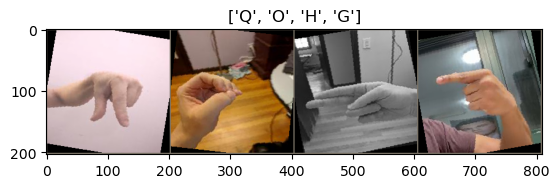

In [250]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

In [251]:
# Now, let’s write a general function to train a model.
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [252]:
# Load a pretrained model and reset final fully connected layer for this particular classification problem.
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the correct device (when we have access to a GPU)
model_ft = model_ft.to(device)

In [253]:
# Let's set our loss function
criterion = nn.CrossEntropyLoss()

In [254]:
# Setup the optimizer to update the model parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

In [255]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [256]:
# Train and evaluate.
# It should take around 10 min on CPU. On GPU, it takes less than a minute.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|█████████████████████████████████████████| 397/397 [00:50<00:00,  7.93it/s]


train Loss: 2.7039 Acc: 0.2456


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 25.16it/s]


val Loss: 1.5259 Acc: 0.5417

Epoch 1/9
----------


100%|█████████████████████████████████████████| 397/397 [00:47<00:00,  8.40it/s]


train Loss: 1.3473 Acc: 0.6417


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 24.74it/s]


val Loss: 0.6421 Acc: 0.8125

Epoch 2/9
----------


100%|█████████████████████████████████████████| 397/397 [00:47<00:00,  8.39it/s]


train Loss: 0.7392 Acc: 0.8161


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 24.56it/s]


val Loss: 0.6007 Acc: 0.8194

Epoch 3/9
----------


100%|█████████████████████████████████████████| 397/397 [00:46<00:00,  8.56it/s]


train Loss: 0.4259 Acc: 0.9125


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 24.76it/s]


val Loss: 0.5518 Acc: 0.8125

Epoch 4/9
----------


100%|█████████████████████████████████████████| 397/397 [00:47<00:00,  8.27it/s]


train Loss: 0.3357 Acc: 0.9288


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 24.87it/s]


val Loss: 0.5869 Acc: 0.8403

Epoch 5/9
----------


100%|█████████████████████████████████████████| 397/397 [00:48<00:00,  8.22it/s]


train Loss: 0.2263 Acc: 0.9565


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 24.50it/s]


val Loss: 0.4571 Acc: 0.8403

Epoch 6/9
----------


100%|█████████████████████████████████████████| 397/397 [00:48<00:00,  8.18it/s]


train Loss: 0.1805 Acc: 0.9628


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 23.14it/s]


val Loss: 0.4762 Acc: 0.8472

Epoch 7/9
----------


100%|█████████████████████████████████████████| 397/397 [00:48<00:00,  8.17it/s]


train Loss: 0.1293 Acc: 0.9798


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 24.28it/s]


val Loss: 0.4458 Acc: 0.8681

Epoch 8/9
----------


100%|█████████████████████████████████████████| 397/397 [00:47<00:00,  8.31it/s]


train Loss: 0.0929 Acc: 0.9912


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 25.98it/s]


val Loss: 0.4830 Acc: 0.8750

Epoch 9/9
----------


100%|█████████████████████████████████████████| 397/397 [00:48<00:00,  8.19it/s]


train Loss: 0.1161 Acc: 0.9824


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 23.76it/s]

val Loss: 0.4196 Acc: 0.8889

Training complete in 8m 15s
Best val Acc: 0.888889


In [257]:
def test_model(model):

    model.eval() # eval mode (not training anymore)
    running_corrects = 0

    # iterate over the test dataset
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # make predictions
        with torch.set_grad_enabled(False):
            outputs = model(inputs).squeeze(1)
            _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)

    # return accuracy
    return running_corrects.double() / dataset_sizes['test']

In [258]:
acc = test_model(model_ft)

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.78it/s]


In [259]:
acc

tensor(0.8919, dtype=torch.float64)

In [260]:
# frame_dir_path = "./data/frames/frame"
# max_frames = 2936

In [261]:
# for frame_no in tqdm(range(2937)):
#     frame_path = frame_dir_path + str(frame_no) + ".jpg"
#     image = Image.open(frame_path)
#     image = np.asarray(image)
#     image = data_transforms["test"](image)

#     print(class_names[torch.argmax(model_ft(image.unsqueeze(0)))])

In [264]:
# https://abauville.medium.com/display-your-live-webcam-feed-in-a-jupyter-notebook-using-opencv-d01eb75921d1
# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        
#         print(frame.shape)
        
        # crop and resize the frame
        crop_width, crop_height = 200, 200  # Adjust these values as per your requirements

        # Get the dimensions of the image
        height, width = frame.shape[:2]

        # Calculate coordinates for the crop
        start_x = (width - crop_width) // 2
        start_y = (height - crop_height) // 2

        # Crop the image
        cropped_image = frame[start_y:start_y + crop_height, start_x:start_x + crop_width]
        
        frame = cv2.resize(frame, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    
        
        frame = cropped_image.astype(np.float32)
        
        print(np.max(frame))
        
#         frame = rescale(image, 0.25)
        
        
#         print(frame.shape)
        new_frame = data_transforms["test"](frame / 255).unsqueeze(0)
#         print(torch.max(new_frame))
        
#         print(new_frame.shape)

        with torch.no_grad():
            pred = class_names[torch.argmax(model_ft(new_frame))]
#         print(pred)
       
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(frame,  
                pred,  
                (50, 50),  
                font, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
        
        _, frame = cv2.imencode('.jpeg', frame)
        
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

[ WARN:30@46118.674] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


None

22.0
183.0
182.0
175.0
173.0
176.0
175.0
178.0
180.0
192.0
193.0
198.0
193.0
197.0
201.0
205.0
204.0
207.0
206.0
204.0
205.0
204.0
207.0
215.0
216.0
218.0
220.0
218.0
217.0
217.0
216.0
218.0
218.0
219.0
218.0
217.0
215.0
211.0
209.0
216.0
212.0
222.0
216.0
215.0
214.0
212.0
210.0
209.0
212.0
215.0
213.0
218.0
215.0
213.0
255.0
253.0
251.0
250.0
254.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0
255.0

221.0
216.0
218.0
219.0
221.0
221.0
218.0
219.0
218.0
216.0
216.0
216.0
216.0
218.0
220.0
222.0
222.0
222.0
223.0
222.0
222.0
222.0
221.0
221.0
222.0
223.0
223.0
221.0
222.0
221.0
221.0
221.0
221.0
221.0
222.0
221.0
222.0
219.0
216.0
217.0
219.0
219.0
223.0
226.0
226.0
223.0
223.0
223.0
222.0
222.0
222.0
221.0
223.0
225.0
224.0
223.0
222.0
223.0
222.0
222.0
222.0
223.0
223.0
224.0
226.0
228.0
225.0
226.0
226.0
223.0
223.0
223.0
223.0
226.0
226.0
228.0
221.0
223.0
219.0
217.0
218.0
218.0
221.0
219.0
217.0
218.0
219.0
221.0
221.0
221.0
221.0
219.0
218.0
218.0
218.0
224.0
224.0
226.0
226.0
224.0
224.0
224.0
224.0
224.0
229.0
229.0
224.0
223.0
223.0
219.0
221.0
224.0
224.0
219.0
221.0
221.0
222.0
218.0
222.0
221.0
219.0
218.0
216.0
220.0
221.0
222.0
223.0
219.0
221.0
216.0
217.0
219.0
221.0
223.0
223.0
224.0
224.0
222.0
223.0
222.0
222.0
224.0
222.0
219.0
217.0
213.0
211.0
211.0
211.0
210.0
209.0
212.0
214.0
216.0
216.0
215.0
215.0
215.0
221.0
216.0
214.0
214.0
209.0
208.0
207.0
207.0
204.

193.0
194.0
192.0
190.0
190.0
190.0
196.0
194.0
194.0
195.0
194.0
192.0
192.0
188.0
191.0
191.0
191.0
188.0
187.0
190.0
191.0
191.0
195.0
197.0
198.0
199.0
200.0
200.0
200.0
200.0
198.0
198.0
197.0
194.0
194.0
191.0
191.0
187.0
188.0
190.0
187.0
188.0
191.0
191.0
194.0
195.0
195.0
193.0
195.0
195.0
193.0
194.0
196.0
201.0
200.0
198.0
194.0
192.0
192.0
190.0
193.0
196.0
197.0
196.0
198.0
202.0
202.0
202.0
197.0
194.0
194.0
194.0
193.0
194.0
192.0
192.0
190.0
188.0
188.0
191.0
192.0
190.0
190.0
190.0
191.0
192.0
190.0
194.0
195.0
191.0
190.0
191.0
193.0
191.0
191.0
189.0
190.0
190.0
192.0
192.0
189.0
188.0
189.0
191.0
193.0
190.0
191.0
194.0
195.0
193.0
193.0
191.0
188.0
188.0
188.0
190.0
190.0
188.0
189.0
187.0
187.0
190.0
190.0
190.0
191.0
191.0
190.0
191.0
192.0
194.0
193.0
193.0
195.0
191.0
192.0
194.0
194.0
195.0
195.0
197.0
201.0
198.0
200.0
196.0
200.0
198.0
198.0
199.0
199.0
199.0
200.0
195.0
198.0
201.0
201.0
200.0
202.0
196.0
197.0
196.0
196.0
200.0
195.0
193.0
186.0
191.0
195.

191.0
192.0
194.0
193.0
192.0
191.0
193.0
190.0
193.0
191.0
193.0
195.0
195.0
200.0
200.0
200.0
200.0
195.0
195.0
195.0
196.0
194.0
195.0
197.0
195.0
194.0
194.0
191.0
193.0
187.0
190.0
191.0
190.0
193.0
193.0
195.0
193.0
192.0
192.0
194.0
192.0
193.0
195.0
191.0
190.0
190.0
187.0
187.0
186.0
188.0
189.0
193.0
191.0
194.0
192.0
189.0
188.0
188.0
191.0
191.0
187.0
188.0
187.0
186.0
190.0
192.0
192.0
190.0
188.0
192.0
188.0
186.0
186.0
188.0
189.0
188.0
188.0
190.0
191.0
190.0
190.0
191.0
193.0
193.0
191.0
190.0
190.0
189.0
187.0
186.0
186.0
190.0
190.0
191.0
190.0
190.0
188.0
191.0
192.0
192.0
191.0
188.0
187.0
190.0
191.0
191.0
193.0
192.0
192.0
194.0
193.0
194.0
193.0
193.0
192.0
193.0
189.0
188.0
188.0
190.0
189.0
190.0
194.0
195.0
195.0
193.0
192.0
194.0
194.0
191.0
190.0
191.0
195.0
199.0
198.0
197.0
195.0
200.0
198.0
196.0
194.0
193.0
194.0
190.0
189.0
189.0
190.0
192.0
193.0
189.0
187.0
190.0
190.0
189.0
187.0
190.0
189.0
188.0
187.0
187.0
186.0
186.0
187.0
190.0
191.0
190.0
186.

222.0
223.0
223.0
223.0
224.0
223.0
223.0
225.0
222.0
222.0
223.0
223.0
223.0
222.0
221.0
221.0
221.0
219.0
221.0
222.0
222.0
222.0
221.0
221.0
220.0
222.0
223.0
223.0
222.0
221.0
222.0
219.0
221.0
219.0
223.0
223.0
221.0
222.0
222.0
219.0
222.0
220.0
220.0
219.0
220.0
221.0
220.0
221.0
222.0
223.0
221.0
223.0
222.0
221.0
222.0
222.0
218.0
216.0
217.0
216.0
216.0
216.0
218.0
216.0
218.0
221.0
222.0
221.0
221.0
219.0
220.0
216.0
213.0
212.0
214.0
217.0
216.0
228.0
217.0
213.0
216.0
220.0
216.0
214.0
215.0
217.0
218.0
220.0
220.0
222.0
221.0
216.0
211.0
207.0
206.0
206.0
207.0
211.0
224.0
225.0
226.0
229.0
229.0
226.0
220.0
217.0
217.0
218.0
218.0
216.0
217.0
238.0
239.0
255.0
255.0
255.0
242.0
217.0
198.0
197.0
228.0
230.0
229.0
215.0
235.0
236.0
236.0
237.0
236.0
235.0
234.0
233.0
231.0
229.0
226.0
222.0
221.0
221.0
219.0
213.0
208.0
202.0
186.0
175.0
172.0
178.0
183.0
187.0
190.0
193.0
194.0
196.0
197.0
198.0
207.0
208.0
208.0
211.0
226.0
233.0
233.0
230.0
227.0
223.0
223.0
228.0
229.

Exception in thread Thread-37:
Traceback (most recent call last):
  File "/Users/akash/anaconda3/envs/acv-final/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/akash/anaconda3/envs/acv-final/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/f5/l11znykj5sj86z8zydv6sbtm0000gn/T/ipykernel_4104/3583600918.py", line 30, in view
AttributeError: 'NoneType' object has no attribute 'shape'


## 